# Overview

## [Introduction to Reinforcement Learning](#introRL) (1 hr)

- What is a Reinforcement Learning?
- What is a policy $\pi$, state space $\mathcal{S}$, action space $\mathcal{A}$ and rewards $R$?
- How do you evaluate a policy (Value functions $V$ and $Q$)?
- How do you compute value functions using Monte Carlo methods?
- How do you improve your policy using Monte Carlo control?

All of these concepts will be introduced through a toy example of playing blackjack. (https://en.wikipedia.org/wiki/Blackjack)

**Packages**

- *Gymnasium*: open source library with APIs for standard benchark environment used to study Reinforcement Learning algorithms (https://gymnasium.farama.org/)
- *Numpy*: open source library for scientifc computing in Python (https://numpy.org/)

### [Link to Exercise Solutions](#ExSolutions)

# What is Reinforcement Learning?

Reinforcement learning is a paradigm for solving problems solely through interactions with an environment. Reinforcement learning is build upon a framework called **Markov Decision Process** which is defined by the following components:

- *States*: a finite set of places (called states here) $S$ an agent can be at a particular point in time *t* ($S_t$). The entire list of possible states is know as the *State Space* and is denoted by *$\mathcal{S}$*.
- *Actions*: a finite set of actions that an agent can take at a particular point in time *t* ($A_t$). The entire list of possible actions is know as the *Action Space* and is denoted by *$\mathcal{A}$*.
- Rewards: a set of rewards that an agent can receive at a particular point in time *t* ($R_t$).
- *Transition probabilities*: probability of transitioning to any given state given you are in a state $S_t$ and take action $A_t$. Denoted as $P(S_{t+1} = s' | S_t = s, A_t = a)$
- *Gamma* ($\gamma$): a constant discount factor on future rewards

The idea is that an **Agent** continuously interacts with an **Environment** (defined using the markov decision process above) with the goal of improving the actions taken by the agent to maximize the rewards received. Pictorally it can be represented as the below feedback loop:

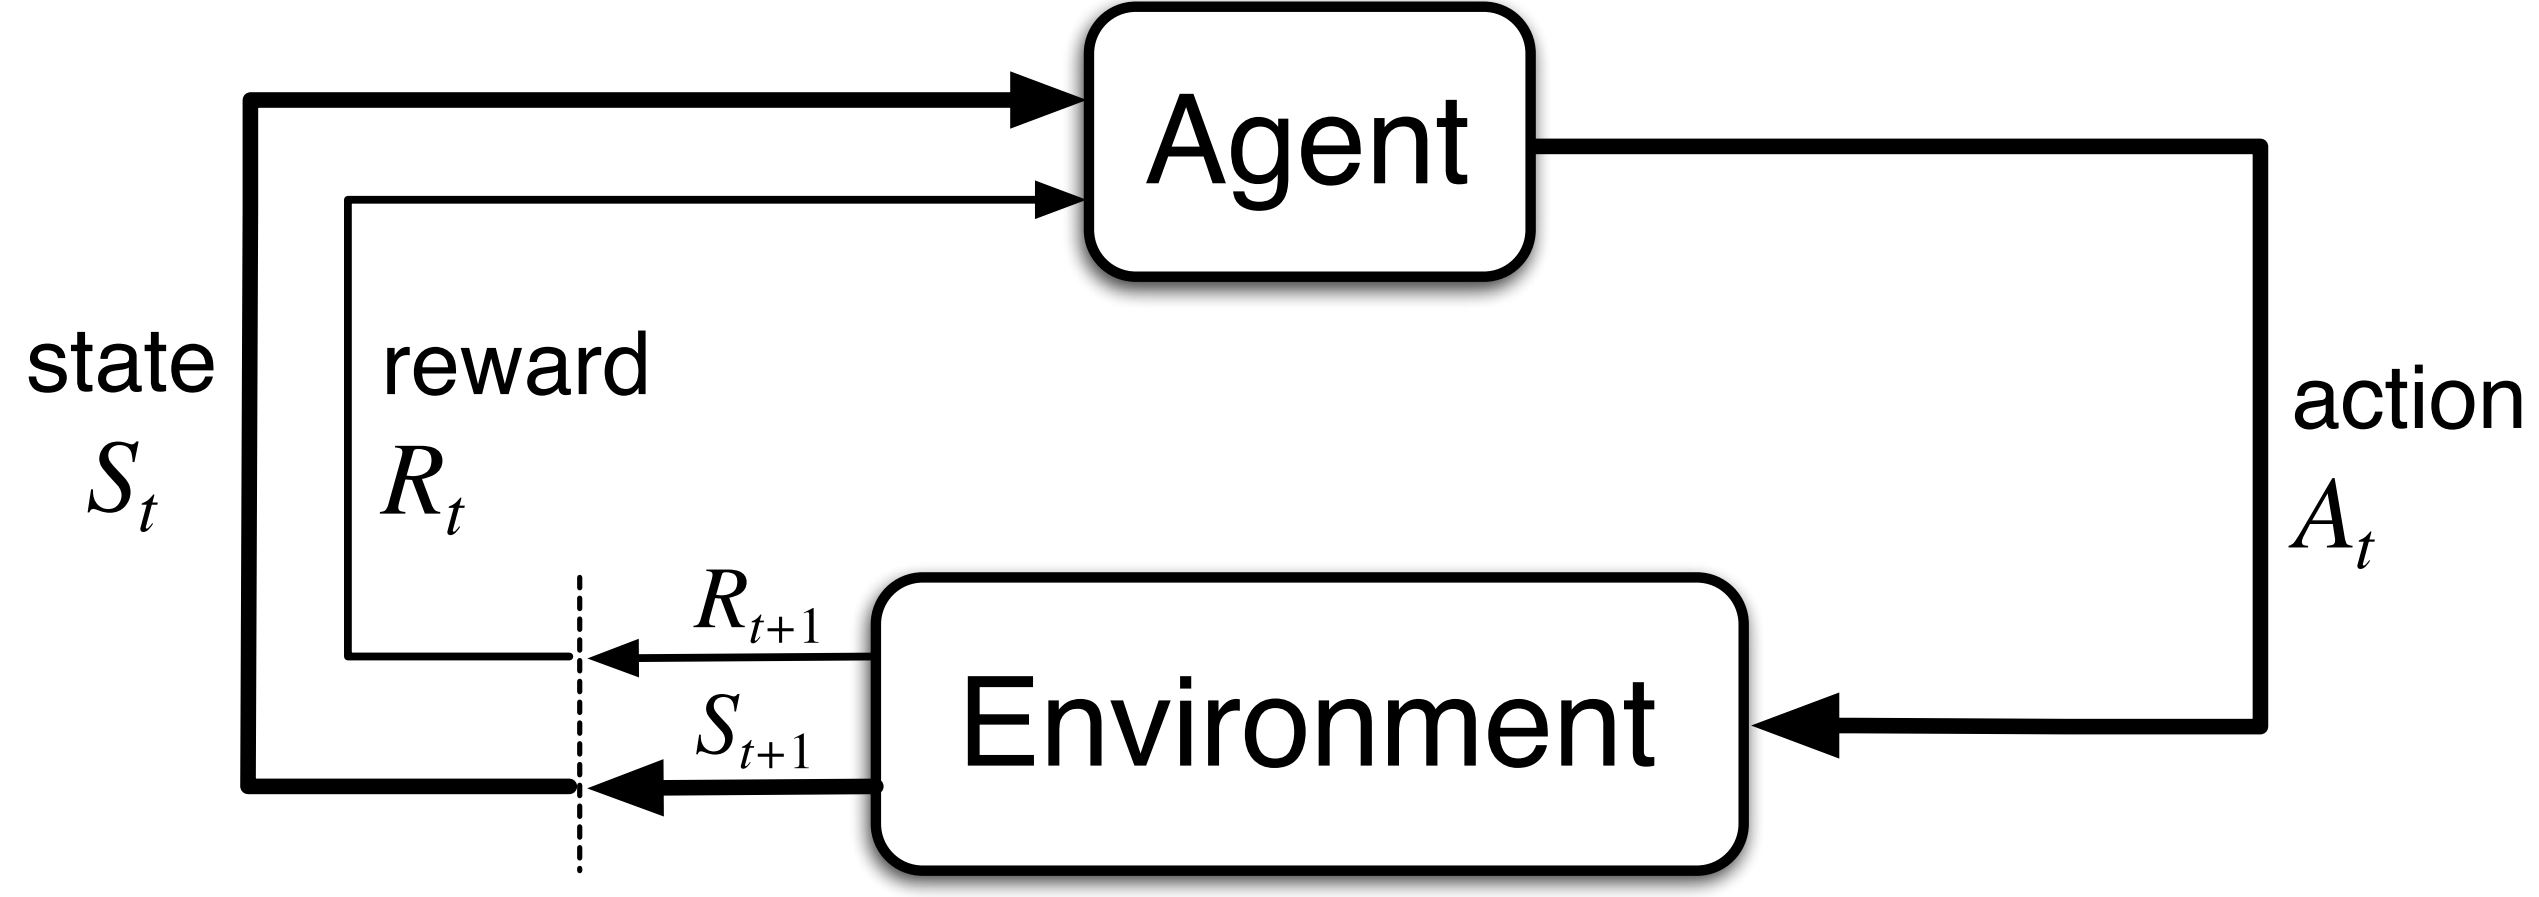

The **Agent** interacts with the environment through a **policy** (denote $\pi$) which defines the behavior of the agent at each state. This can be seen as a mapping (or function) from states to actions and can be modeled as a conditional probability distribution given we are in a particular state: 
$$
\pi(a|s) = P(A_t = a| S_t = s)
$$

Many problems can be mapped to this type of framework and therefore allow us to use Reinforcement Learning techniques to solve them. The one we will be looking at in this workshop is blackjack.

## Link to finance

**Return** (denoted $G$), is the cummulative sum of rewards received:
$$
G = R_1 + \gamma R_2 + \gamma^2 R_3 + ... = \sum_{t = 0}^\infty \gamma^t R_{t + 1} 
$$
This quantity and its use of $\gamma$ is very similar to how we compute NPVs in finance by discounting future cash flows to receive the present value of a security.

As a demontrative example we could model an asset allocation problem as a MDP to be solved using Reinforcement Learning:
- *States*: A vector representing the amount of each asset I'm holding onto at time *t*.
- *Actions*: The quantity of money one chooses to use to re-invest into a set of distincts securities.
- *Rewards*: rewards received from investements.


With the goal being to maximize long-term returns.

# Learning to play Blackjack with Monte Carlo methods <a name='IntroRL'>

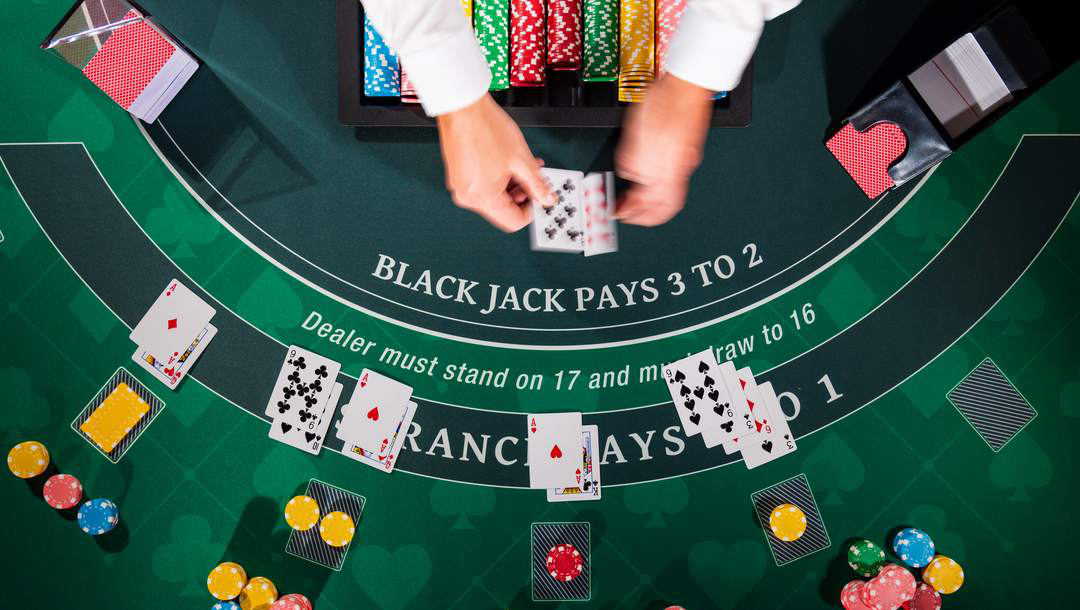

## Setting up the environment

We'll be using a library called `gymnasium` that has many simpler interfaces for interacting with environments used to test Reinforcement Learning algorithms. They have an pre-build environment for blackjack:
https://gymnasium.farama.org/environments/toy_text/blackjack/

In [1]:
import gymnasium as gym

In [2]:
import numpy as np
from collections import defaultdict
from typing import Tuple, Sequence, Callable, Mapping, Union
from tqdm import tqdm 
import matplotlib.pyplot as plt

# visualization helper methods 
from assets import blackjack_plots

In [3]:
# set the random seed
np.random.seed(2)

In [4]:
# create blackjack environment
env = gym.make('Blackjack-v1', sab = True)

## Environment representation

In [5]:
env.action_space # number of actions available (0 "stay" or 1 "hit")

Discrete(2)

The **Actions** we have available are just binary ${0,1}$.

In [6]:
env.observation_space # the state space is comprised of (total_player, visible_card_dealer, Whether or not I have an Ace)
                      # total player is in the range [4 - 32]
                      # visible_card_dealer in range [Ace, 2, 3, .., 10]
                      # Whether or not I have a usable ace: True/False

Tuple(Discrete(32), Discrete(11), Discrete(2))

The **States** here consists of a tuple of 3 elements: 

$S = (PlayerScore, DealerCardShowing, UsableAce)$

In [7]:
PlayerTotal = int
DealerCard = int
UsableAce = bool

State = Tuple[PlayerTotal, DealerCard, UsableAce]

## Interacting with the environment

- Step 1: Reset the environment and get the first state.

In [8]:
# reset the environment, get the first state
env.reset() 

((10, 10, 0), {})

- Step 2: Take an action, e.g. hit = 1 and see the resulting next state

In [9]:
action = 1 # hit
env.step(action) # returns ((current state), reward, termination, truncation, info) 

((13, 10, 0), 0.0, False, False, {})

### Exercise 1 (2 minutes) <a name='ex1'>

Play a few rounds of blackjack yourself against the dealer and see if you can beat them!

Run the cell below (re-run to replay) and input your action (hit = 1 or stay = 0).

**Note**: Don't forget to finish the game before moving forward with the notebook. Otherwise the interpreter will hang waiting for your next move.

In [10]:
print(f"{'*'*40}")
print(f"*  Play Blackjack against the dealer!  *")
print(f"{'*'*40}")

print("Game Start: \n")

state = env.reset()[0]

time_counter = 0
actions = [0, 1]

game_over = False
while not game_over:
    
    time_counter += 1
    player_total, dealer_card, usable_ace = state
    print(f"State at time t = {time_counter}: \n o Player Total: {player_total}, \n o Dealer Card Showing: {dealer_card},\n o Usable Ace: {usable_ace}")

    # retrieve action from player
    while True:
        try:
            action = int(input("-> Please select an action (Stay = 0 or Hit = 1): ")) 
            
            if action not in actions:
                raise ValueError
            
            break
        except ValueError:
            print("Oops! That was not a valid action. Please try again ...")

    # take action 
    print(f"Taking action: {'Stay' if not action else 'Hit'}")
    
    # transition and receive reward
    state, reward, game_over, _, _ = env.step(action)
    print(f"Receive reward: {reward} \n")
    
print(f"Game End: {'You win! :D' if reward > 0 else 'You lose! :('}")
print(f"{'*'*40}")

****************************************
*  Play Blackjack against the dealer!  *
****************************************
Game Start: 

State at time t = 1: 
 o Player Total: 17, 
 o Dealer Card Showing: 2,
 o Usable Ace: 0


-> Please select an action (Stay = 0 or Hit = 1):  0


Taking action: Stay
Receive reward: 1.0 

Game End: You win! :D
****************************************


## Defining a policy $\pi$

The policy is what you have control over. You define the behavior of the agent through it and it can be thought of as a map between states and actions ($\pi: S \rightarrow A$). We can represent it as a probability distribution:


- Assign to each possible state a probablity distribution over actions (either 0 or 1) 

$$
P(Action = 0|PlayerScore, DealerScore, AceShowing)
$$
and 
$$
P(Action = 1|PlayerScore, DealerScore, AceShowing)
$$


In [11]:
ActionProb = np.ndarray[float, float]

In [12]:
def random_policy(player_state: State) -> ActionProb:
    ''' sampling an action at random '''
    return np.array([0.5, 0.5])


### Visualizing the policy

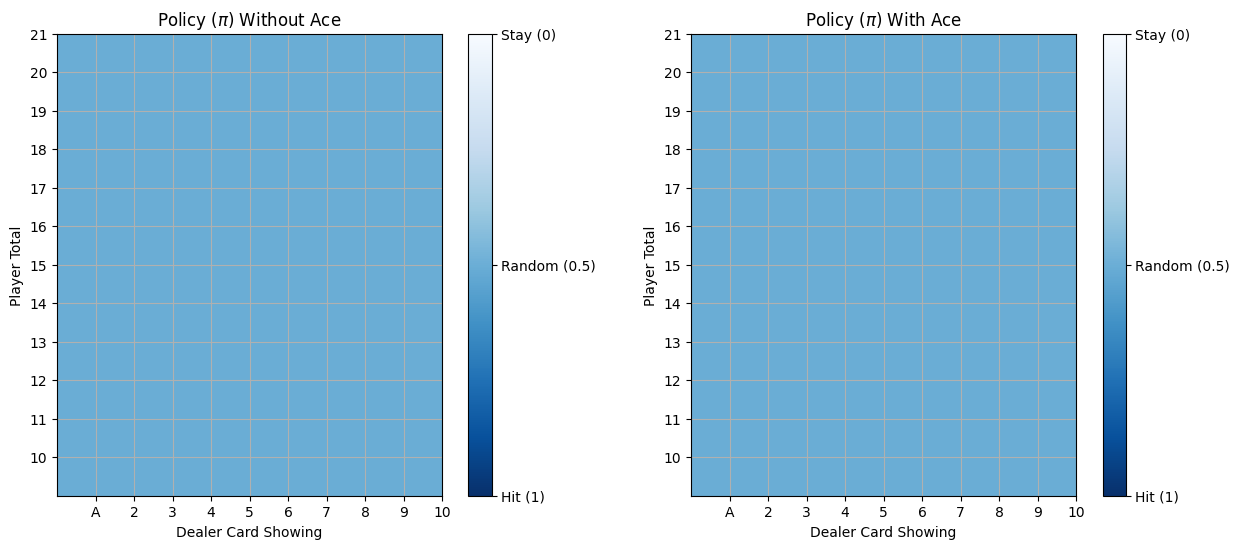

In [13]:
# random policy, so for every state we have probability 0.5
blackjack_plots.plot_policy(random_policy)

In [14]:
def naive_policy(player_state: State) -> ActionProb:
    ''' an implementation of a naive policy '''
    
    player_total, deal_card_showing, ace = player_state
 
    # if I have 20 or 21 "stay"
    if player_total >= 20:
        return np.array([1, 0]) 
    
    # otherwise "hit"
    else:
        return np.array([0, 1])
        

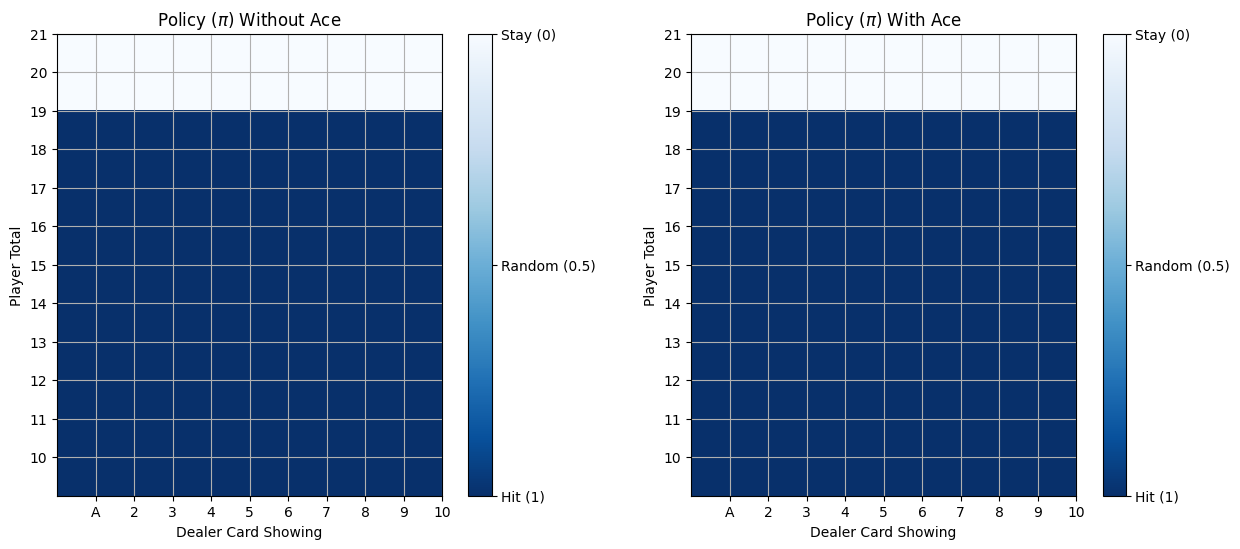

In [15]:
blackjack_plots.plot_policy(naive_policy)

### Exercise 2 (5 minutes) <a name='ex2'>

Create your own policy! Fill out the below code snippet with whatever policy you think is better for playing blackjack (we will evaluate it later!). Visualize your policy afterwards to make sure it represents what you had in mind.

In [16]:
''' Create your own policy and see how good it performs! '''
def my_policy(player_state: State) -> ActionProb:

    '''example policy, create your own!'''
    player_total, deal_card_showing, ace = player_state
 
    # always return stay
    return np.array([1.0, 0.0])

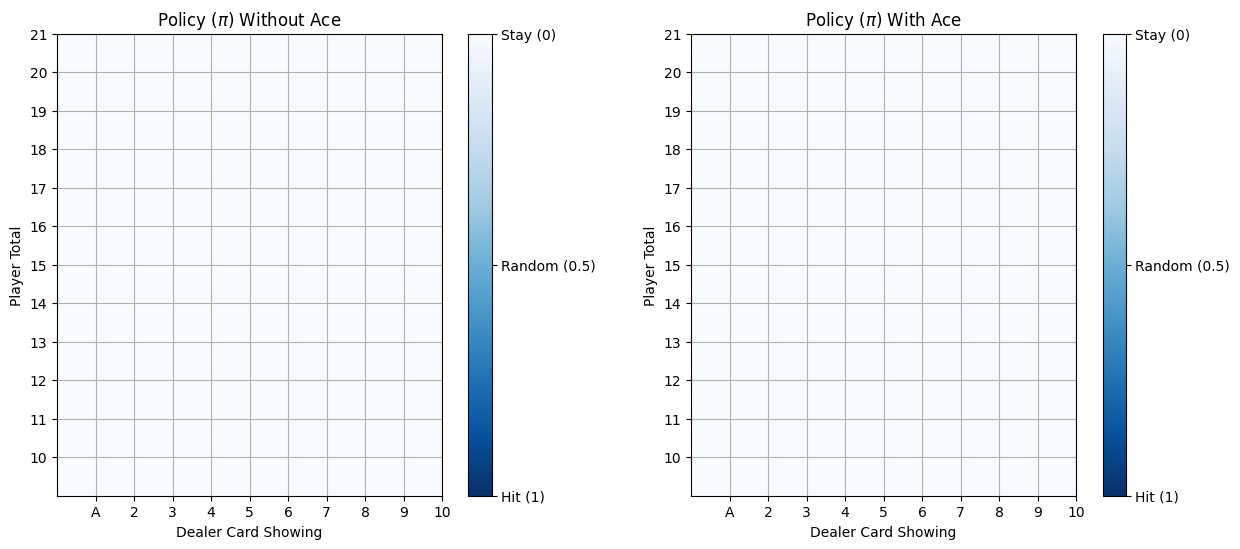

In [17]:
blackjack_plots.plot_policy(my_policy)

[Solution](#ex2sol)

## Generating Episodes

Now that we have the basics, we need to create data (a lot of it!). Data in our case are **episodes**, full length rollout of our agent interacting with the environment until termination.

In [18]:
Action = int  # either 0 or 1
Reward = int

Episode = list[State, Action, Reward]
Episodes = list[Episode]

In [19]:
def generate_episode(policy:Union[Callable, Mapping[State, ActionProb]]) -> Episode:
    '''
    Function to generate an episode following a policy
    '''
    
    episode = []            # store the episode
    state = env.reset()[0]  # start the game
    
    game_over = False
    while not game_over:
        
        # get action
        action_prob = policy[state] if isinstance(policy, dict) else policy(state)
        action = np.random.choice(actions, 1, p = action_prob)[0]

        # take action in environement
        next_state, reward, game_over, _, _ = env.step(action)

        # append outcome
        episode.append((state, action, reward))
        
        state = next_state
    
    return episode

In [20]:
def generate_episodes(policy: Union[Callable, Mapping[State, ActionProb]], num_episodes: int) -> list[Episode]:
    '''Generate multiple episodes'''
    
    episodes = []

    for _ in range(num_episodes):
        episodes.append(generate_episode(policy))
        
    return episodes

In [21]:
# example of generating a random episode
generate_episode(random_policy)

[((17, 10, 0), 0, -1.0)]

In [22]:
# example of generating an episode following a naive policy
generate_episode(naive_policy)

[((9, 10, 0), 1, 0.0), ((11, 10, 0), 1, 0.0), ((21, 10, 0), 0, 1.0)]

In [23]:
# generate multiple episodes
episodes = generate_episodes(naive_policy, 1_000)

In [24]:
episodes[:10]

[[((18, 2, 0), 1, -1.0)],
 [((12, 7, 0), 1, 0.0), ((15, 7, 0), 1, -1.0)],
 [((7, 10, 0), 1, 0.0), ((17, 10, 0), 1, -1.0)],
 [((9, 2, 0), 1, 0.0), ((12, 2, 0), 1, -1.0)],
 [((12, 2, 1), 1, 0.0), ((18, 2, 1), 1, 0.0), ((13, 2, 0), 1, -1.0)],
 [((11, 1, 0), 1, 0.0), ((21, 1, 0), 0, 1.0)],
 [((15, 7, 0), 1, 0.0), ((20, 7, 0), 0, 1.0)],
 [((19, 4, 0), 1, -1.0)],
 [((13, 3, 0), 1, 0.0), ((17, 3, 0), 1, -1.0)],
 [((18, 5, 0), 1, 0.0), ((19, 5, 0), 1, -1.0)]]

### Exercise 3 (5 minutes) <a name='ex3'>

Write a function to get the **return** from an episode. Don't forget to include the discount factor!

In [25]:
def get_return(episode: Episode, start_index: int = 0, discount: float = 1.0) -> Union[int, float]:
    '''
    Function to get the discounted return (total rewards) of an episode
    '''
    pass

In [27]:
# test
assert get_return(episodes[0], start_index = 0, discount = 1.0) == episodes[0][-1][-1]

[Solution](#ex3sol)

## Evaluating a policy

Now that we know what a policy *is*, we would like to know *how well* we would perform if we follow it. We can quantify this idea as the expected sum of rewards we would get from following this policy. In reinforcement learning, this is called the **Value Function** (denoted $V_{\pi}$).

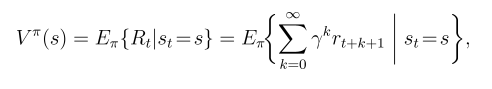

An associated quantity very similar to the value function is called the **action-value function** (denoted $Q_{\pi}$). The only difference is in conditioning on the first action taken before evaluating the expected reward we would get thereafter.

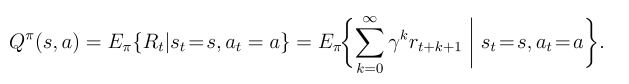

In [28]:
V_type = Mapping[State, float]
Q_type = Mapping[Tuple[State, Action], float]

There are several ways of actually computing these quantities, here we will focus on a Monte Carlo approach.

## Monte Carlo Estimation

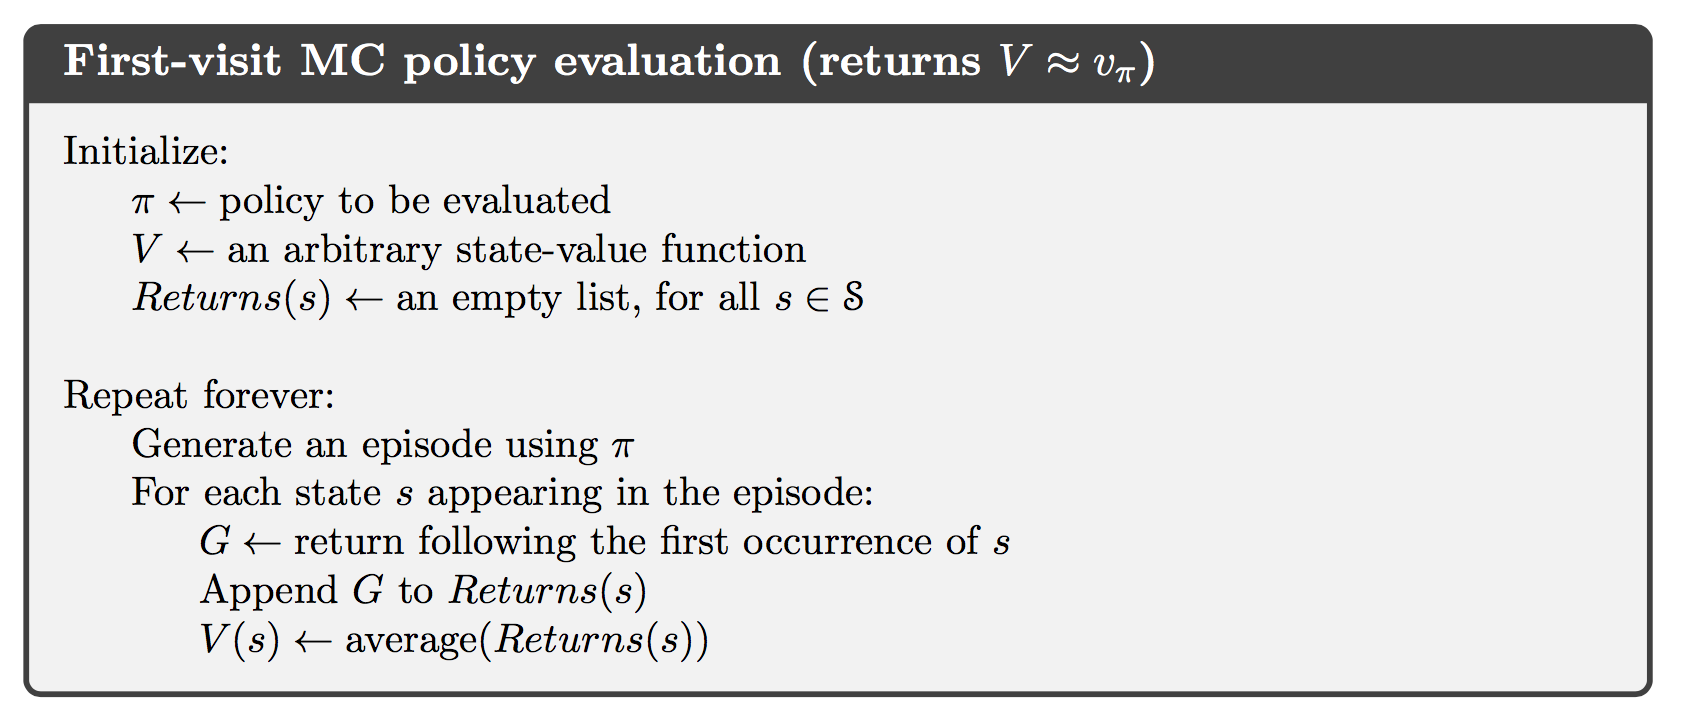

### Exercise 4 (15 mins) <a name='ex4'>
The function below provides the boilerplate for-loop for the first-visit MC policy evaluation algorithm above. This exercise asks you complete the function to compute the value function $V$. Use the pseudo-code above to help complete the function.

In [29]:
def mc_estimation_V(episodes: Episodes, discount: int = 1.0) -> V_type:
    '''
    Implement first visit Monte Carlo estimation
    '''
    V = {}
    # add any additional variables you think you might need to keep track of
    
    for episode in episodes:
        states_visited_during_episode = set()
        
        for index, step in enumerate(episode):
            
            state, action, reward = step
            
            if state not in states_visited_during_episode:
                states_visited_during_episode.add(state)
                
                # complete the function to compute V
                ...
                
    return V

[Solution](#ex4sol)

### Estimate policy performance

In [32]:
naive_episodes = generate_episodes(naive_policy, 50_000)
rand_episodes = generate_episodes(random_policy, 50_000)

In [33]:
naive_V = mc_estimation_V(naive_episodes)
rand_V = mc_estimation_V(rand_episodes)

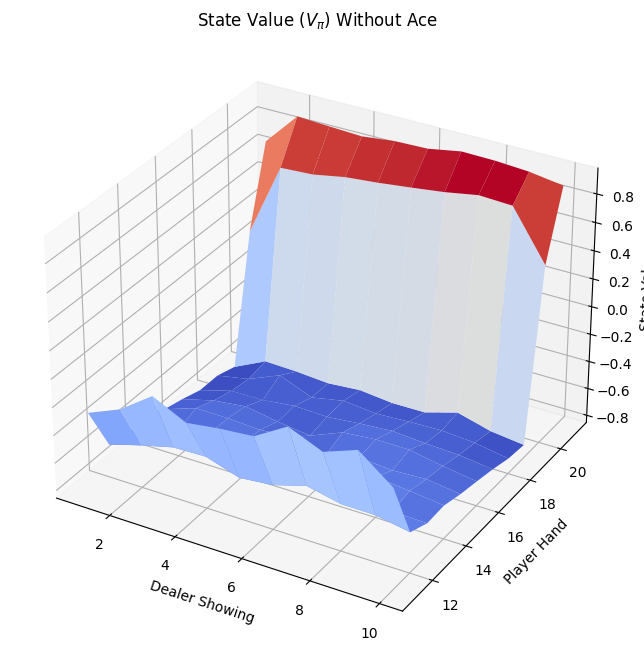

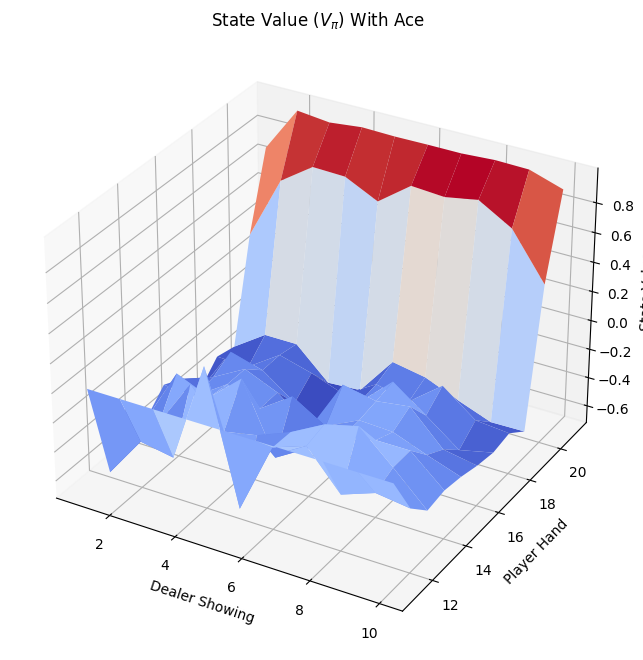

In [34]:
blackjack_plots.plot_values(naive_V)

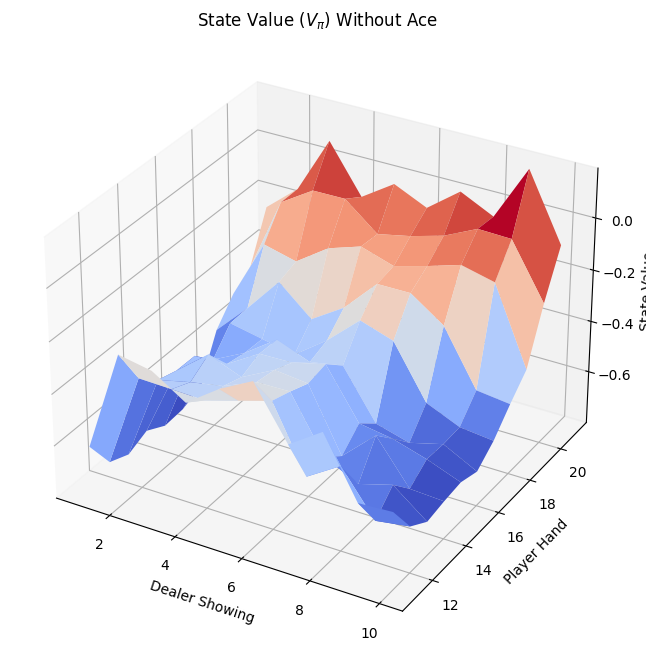

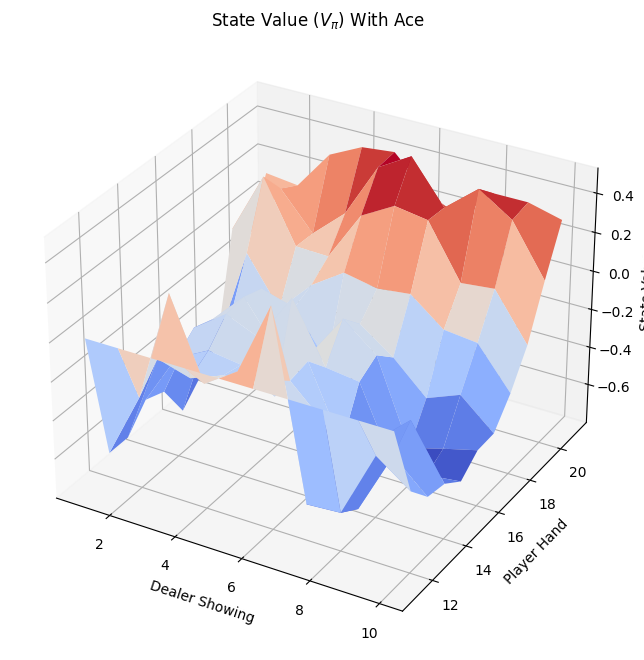

In [35]:
blackjack_plots.plot_values(rand_V)

# Monte Carlo Control

Now that we know how to evaluate a policy, the next question is how to make it better (This is referred to as the control problem). It turns out we can just we just be greedy with respect to the action that would give us the largest $Q$ value.

This leads us to the following MC control algorithm:

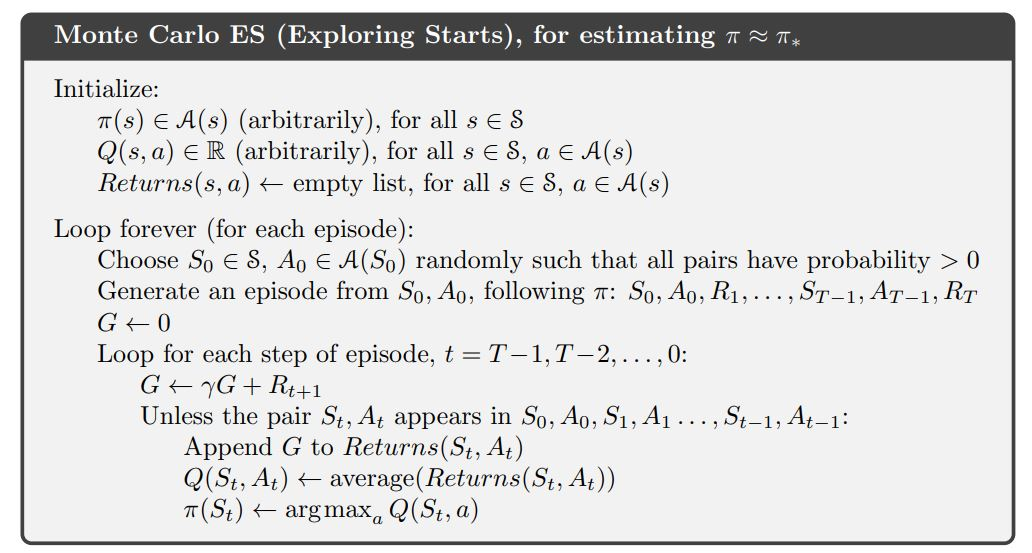

In [36]:
num_episodes = 500_000

## Hyperparameters

In [37]:
final_epsilon = 0.1
start_epsilon = 1.0
epsilon_decay = start_epsilon / (num_episodes / 2)

In [38]:
def update_epsilon(epsilon):
    return max(final_epsilon, epsilon - epsilon_decay)

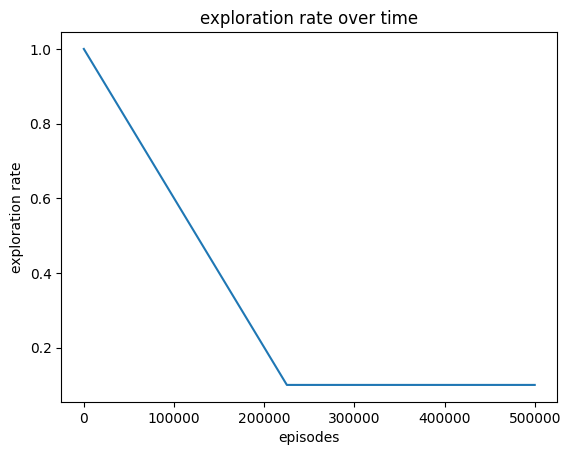

In [39]:
# Visualizing this decay
import matplotlib.pyplot as plt

t = np.arange(0, num_episodes)
y = [start_epsilon]
for i in t[:-1]:
    y.append(update_epsilon(y[-1]))


plt.plot(t, y)
plt.xlabel("episodes")
plt.ylabel("exploration rate")
plt.title("exploration rate over time")
plt.show()

## Defining the agent

In [40]:
class MonteCarloBlackjackAgent:
    def __init__(
        self,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 1,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.N = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(lambda: np.zeros(env.action_space.n))
        
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        

    def get_action(self, state: State) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.Q[state]))

    def update(
        self,
        episode: list[State, Action, Reward],
    ):
        visited_state_actions = set()
        for index, step in enumerate(episode):
            state, action, reward = step
            
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                self.returns[state][action] += get_return(episode, index, discount = mc_agent.discount_factor)
                self.N[state][action] += 1
                self.Q[state][action] = self.returns[state][action] / self.N[state][action]
            

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [41]:
mc_agent = MonteCarloBlackjackAgent(
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

## Training

In [42]:
# training loop
env = gym.make('Blackjack-v1', sab = True) # create blackjack environment
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)

for episode_num in tqdm(range(num_episodes)):
    state, info = env.reset()
    done = False

    # play one episode
    episode = []
    while not done:

        action = mc_agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        episode.append((state, action, reward))
        
        done = terminated or truncated
        state = next_state
        
    # update the agent
    mc_agent.update(episode)
    mc_agent.decay_epsilon()

100%|█████████████████████████████████████████████████████████████████████████████████| 500000/500000 [03:48<00:00, 2185.80it/s]


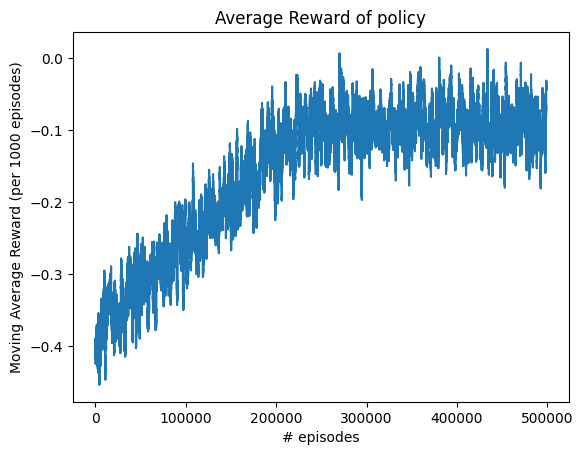

In [43]:
# plot average reward 

moving_avg_length = 1000

plt.plot(np.convolve(np.array(env.return_queue).flatten(), np.ones(moving_avg_length), mode = 'valid') / moving_avg_length)
plt.xlabel('# episodes')
plt.ylabel(f'Moving Average Reward (per {moving_avg_length} episodes)')
plt.title("Average Reward of policy")
plt.show()

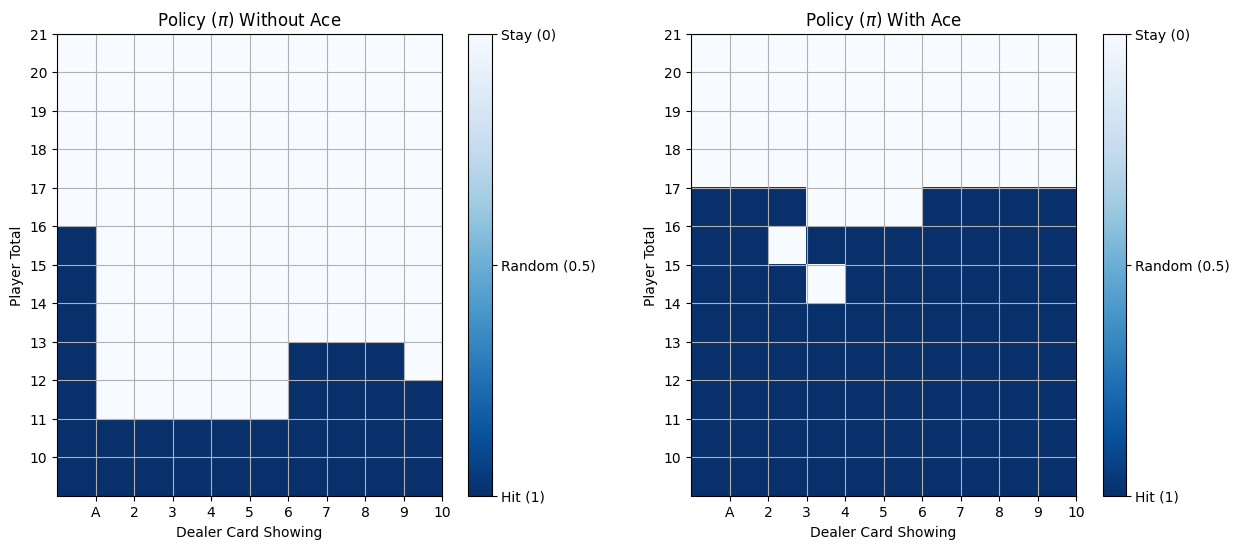

In [44]:
blackjack_plots.plot_policy(blackjack_plots.dict_Q_values_to_array(mc_agent.Q))

## Compare with Optimal Policy

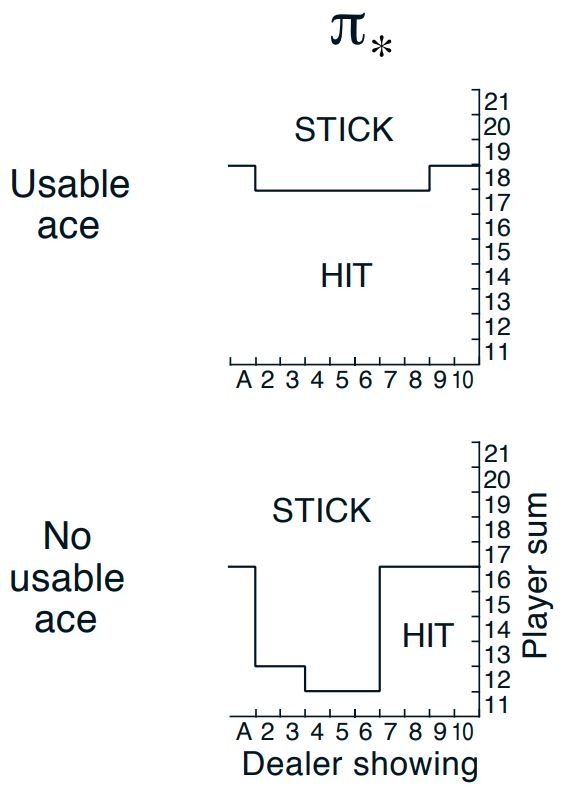

Figure from Sutton and Barto Reinforcement Learning: An Introduction (http://incompleteideas.net/book/the-book-2nd.html)

## Compare with other policies

In [45]:
mc_policy = blackjack_plots.policy_from_Q(mc_agent.Q)

In [ ]:
mc_policy_episodes = generate_episodes(mc_policy, 50_000)

In [55]:
mc_V = mc_estimation_V(mc_policy_episodes)

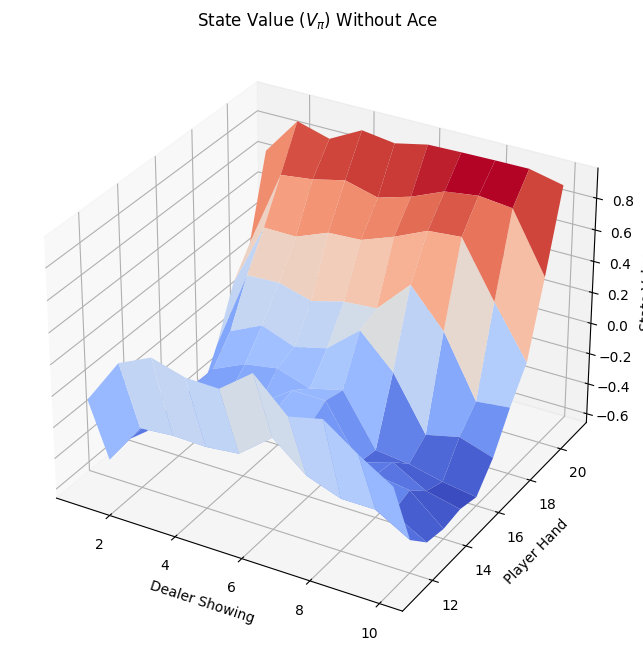

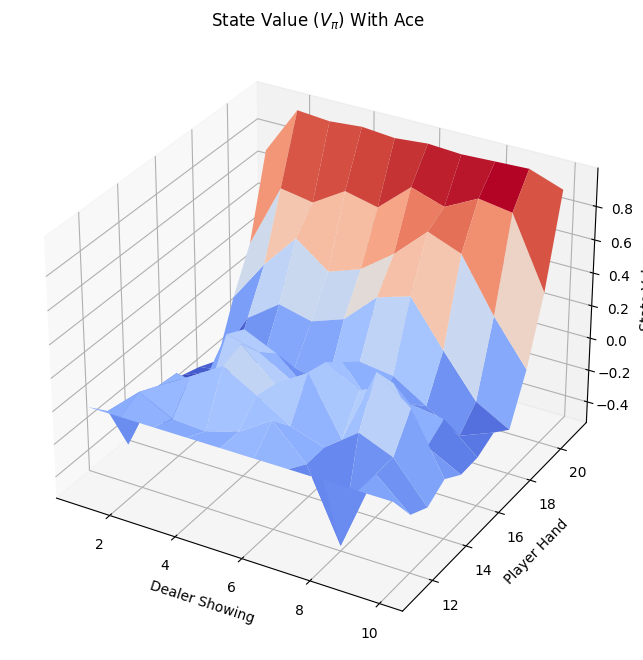

In [56]:
blackjack_plots.plot_values(mc_V)

In [57]:
average_reward_mc_policy = sum([get_return(episode) for episode in mc_policy_episodes]) / len(mc_policy_episodes)
average_reward_naive_policy = sum([get_return(episode) for episode in naive_episodes]) / len(naive_episodes)
average_reward_rand_policy = sum([get_return(episode) for episode in rand_episodes]) / len(rand_episodes)

print(f'Average reward for MC policy over 50 000 epsiodes: {average_reward_mc_policy} \n\
Average reward for naive policy over 50 000 epsiodes: {average_reward_naive_policy} \n\
Average reward for random policy over 50 000 epsiodes: {average_reward_rand_policy}')

Average reward for MC policy over 50 000 epsiodes: -0.0596 
Average reward for naive policy over 50 000 epsiodes: -0.34542 
Average reward for random policy over 50 000 epsiodes: -0.39886


# Exercise Solutions <a name='ExSolutions'>

## Exercise 2 <a name='ex2sol'>

In [20]:
''' No solution to this problem, up to you! '''
def my_policy(player_state: State) -> ActionProb:
    
    background_color = np.array([0.5, 0.5])
    forground_color = np.array([0, 1])
    
    important_states = {
        (17, 4),
        (17, 7),
        (14, 2), 
        (13, 3), 
        (12, 4), 
        (12, 5), 
        (12, 6), 
        (12, 7), 
        (13, 8), 
        (14, 9)
    }
    
    other_important_states = {
        (17, 4),
        (17, 7),
        (12, 2), 
        (13, 3), 
        (13, 4), 
        (13, 5), 
        (13, 6), 
        (13, 7), 
        (13, 8), 
        (12, 9)
    }
    
    player_total, deal_card_showing, ace = player_state
    
    if not ace and (player_total, deal_card_showing) in important_states:
        return forground_color
    
    if ace and (player_total, deal_card_showing) in other_important_states:
        return forground_color
    
    return background_color

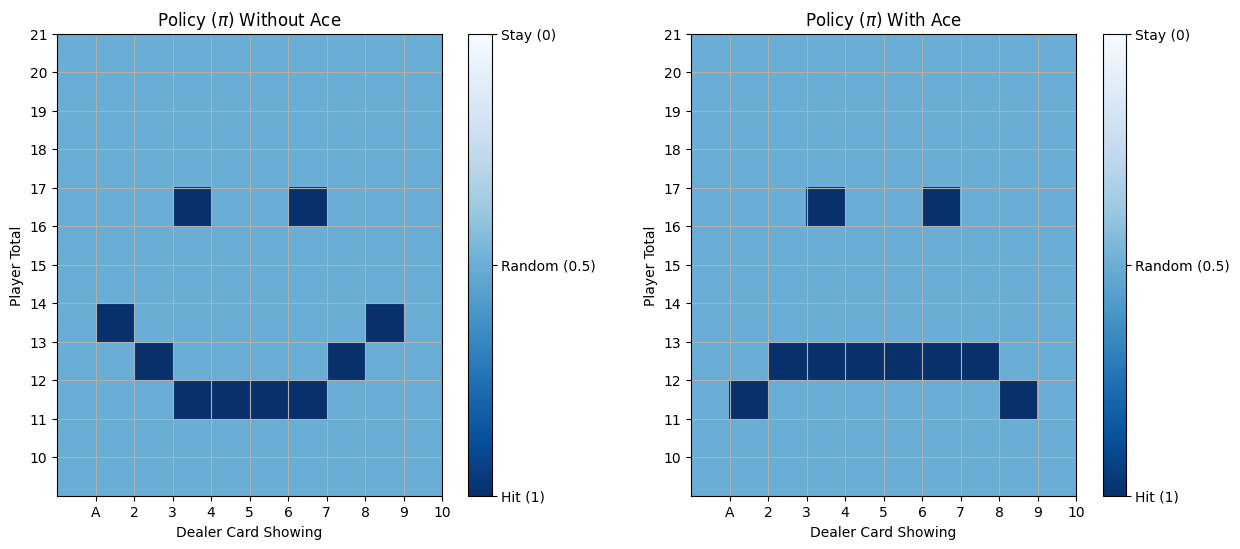

In [21]:
blackjack_plots.plot_policy(my_policy)

[Back](#ex2)

## Exercise 3 <a name='ex3sol'>

In [26]:
def get_return(episode: Episode, start_index: int = 0, discount: int = 1.0) -> Union[int, float]:
    '''
    Function to get the discounted return of an episode
    '''
    if start_index > len(episode):
        raise ValueError
    
    total = 0
    
    for i in range(start_index, len(episode)):
        state, action, reward = episode[i]
        
        total += (discount ** i) * reward

    return total

[Back](#ex3)

## Exercise 4 <a name='ex4sol'>

In [30]:
def mc_estimation_V(episodes: Episodes, discount: int = 1.0):
    '''
    Implementation of first visit Monte Carlo estimation V
    '''
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    N = defaultdict(float)
    
    for episode in episodes:
        
        states_visised_during_episodes = set()
        
        for index, step in enumerate(episode):
            
            state, action, reward = step
            
            if state not in states_visised_during_episodes:
                states_visised_during_episodes.add(state)
                
                r = get_return(episode, index, discount = discount)
                returns_sum[state] += r
                N[state] += 1
                V[state] = returns_sum[state] / N[state]
                
    return V

In [31]:
def mc_estimation_Q(episodes: Episodes, discount: int = 1.0):
    '''
    Implementation of first visit Monte Carlo estimation Q
    '''
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in episodes:
        
        state_actions_visited_during_episode = set()
        
        for index, step in enumerate(episode):
            
            state, action, reward = step
            
            if (state, action) not in state_actions_visited_during_episode:
                
                state_actions_visited_during_episode.add((state, action))
                
                r = get_return(episode, index, discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
            
    return Q

[Back](#ex4)

# References

All diagrams where taken from [1] and inspiration for some of the code was taken from [2]

[1] Sutton and Barto Reinforcement Learning: An Introduction (http://incompleteideas.net/book/the-book-2nd.html)

[2] Tutorial from Gynamsium documentation (https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)